# References and variables

In [1]:
#import warnings
#warnings.filterwarnings('ignore')

import sys
sys.path.append('../fastai/old/') #fastai version 0.7

from fastai.conv_learner import *
from fastai.dataset import *
import fastai.transforms

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import scipy.optimize as opt

from torchsummary import summary
from torchvision.models import *
from pathlib import Path

from functools import partial, update_wrapper

In [2]:
PATH = Path('/home/Deep_Learner/work/network/datasets/human-protein-atlas-image-classification/stage1_data')
TRAIN = PATH/'base(all_cls)_and_extra_data(only_cls:[8, 9, 10, 15, 17, 20,24, 26, 27])_pngs_512'
TEST = PATH/'test_pngs_512'
LABELS = PATH/'base(all_cls)_and_extra_data(only_cls:[8, 9, 10, 15, 17, 20, 24, 26, 27])_without_broken_and_missing_pngs_512.csv'
LABELS_EXTRA_ONLY = PATH/'extra_data(only_cls:[8, 9, 10, 15, 17, 20, 24, 26, 27])_without_broken_and_missing_pngs_512.csv')
SAMPLE = PATH/'sample_submission.csv'

TRAIN_NAMES_BASE = PATH/'tr_names(just_base).csv'
VAL_NAMES_BASE = PATH/'val_names(just_base).csv'

name_label_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

nw = 8   #number of workers for data loader
torch.cuda.set_device(0)
torch.backends.cudnn.benchmark=True
np.random.seed(42)

# Data

In [3]:
def remove_suffix(s:str):
    """
    Removes the '_red', '_green', '_blue', '_yellow' suffix and everything coming afterwards from the filename
    """
    suffixes = ['_red', '_green', '_blue', '_yellow']
    for suf in suffixes:
        if suf in s:
            return s[:s.find(suf)]
        else:
            continue            

In [4]:
#broken ids in 'base_and_extra_data_pngs_512' folder checked with:
#for n in train_names:
    #open_rgby(path=TRAIN, id=n)
#broken_ids =    ['21213_si24_C7_8',
#                '35812_1303_F4_4',
#                '15331_932_C2_2',
#                '62743_1246_E5_2',
#                '37528_448_A11_2',
#                '58495_1336_H3_3',
#                '36287_1042_G10_3']
#
#train_names = list({remove_suffix(f) for f in os.listdir(TRAIN)})
#for i in broken_ids:
#    train_names.remove(i)
#test_names = list({remove_suffix(f) for f in os.listdir(TEST)})
#tr_n, val_n = train_test_split(train_names, test_size=0.2, random_state=42) #split train set into train and val set

In [ ]:
tr_n = list(pd.read_csv(TRAIN_NAMES_BASE).Id)
val_n = list(pd.read_csv(VAL_NAMES_BASE).Id)

#extra_data ids
ids_extra = list(set(pd.read_csv(LABELS_EXTRA_ONLY).Id))
t, v = train_test_split(ids_extra, test_size=0.2, random_state=42)
for i in t:
    tr_n.append(i)
for i in v:
    val_n.append(i)
    
test_names = list({remove_suffix(f) for f in os.listdir(TEST)})

In [5]:
len(tr_n)

29764

In [ ]:
print(len(tr_n)+len(val_n))

In [ ]:
print(len(pd.read_csv(LABELS).Id))

In [6]:
#creating duplicates for rare classes in train set
class Oversampling:
    def __init__(self,path):
        self.train_labels = pd.read_csv(path).set_index('Id')
        self.train_labels['Target'] = [[int(i) for i in s.split()] 
                                       for s in self.train_labels['Target']]  
        #set the minimum number of duplicates for each class
        #self.multi = [1,1,1,1,1,1,1,1,4,4,4,1,1,1,1,4,1,1,1,1,2,1,1,1,1,1,1,4]
        self.multi = [1,1,1,1,1,1,1,1,2,2,3,1,1,1,1,5,1,1,1,1,1,1,1,1,1,1,1,4]
    def get(self,image_id):
        labels = self.train_labels.loc[image_id,'Target'] if image_id \
          in self.train_labels.index else []
        m = 1
        for l in labels:
            if m < self.multi[l]: m = self.multi[l]
        return m
    
s = Oversampling(LABELS)
tr_n = [idx for idx in tr_n for _ in range(s.get(idx))]
print(len(tr_n),flush=True)

30762


In [7]:
def open_rgby(path,id): #a function that reads RGBY image
    try:
        colors = ['red','green','blue','yellow']
        flags = cv2.IMREAD_GRAYSCALE
        img = [cv2.imread(os.path.join(path, id+'_'+color+'.png'), flags).astype(np.float32)/255
               for color in colors]
        return np.stack(img, axis=-1)
    except:
        print(id)

class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.labels = pd.read_csv(LABELS).set_index('Id')
        self.labels['Target'] = [[int(i) for i in s.split()] for s in self.labels['Target']]
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        img = open_rgby(self.path,self.fnames[i])
        if self.sz == 512: return img 
        else: return cv2.resize(img, (self.sz, self.sz),cv2.INTER_AREA)
    
    def get_y(self, i):
        if(self.path == TEST): return np.zeros(len(name_label_dict),dtype=np.int)
        else:
            labels = self.labels.loc[self.fnames[i]]['Target']
            return np.eye(len(name_label_dict),dtype=np.float)[labels].sum(axis=0)
        
    @property
    def is_multi(self): return True
    @property
    def is_reg(self):return True
    #this flag is set to remove the output sigmoid that allows log(sigmoid) optimization
    #of the numerical stability of the loss function
    
    def get_c(self): return len(name_label_dict) #number of classes
    

def get_data(sz,bs,is_test=False):
    #data augmentation
    if is_test:
        aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                    RandomDihedral(tfm_y=TfmType.NO)]
    else:
        aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                    RandomDihedral(tfm_y=TfmType.NO),
                    RandomLighting(0.05, 0.05, tfm_y=TfmType.NO),
                    Cutout(n_holes=25, length=10*sz//128, tfm_y=TfmType.NO)]
    #mean and std in of each channel in the train set
    #stats = A([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])
    #stats = A([0.07769, 0.0538 , 0.05758, 0.08284], [0.12122, 0.0921 , 0.1372 , 0.12723])
    #image-net stats:
    imagenet_stats = ([0.485, 0.456, 0.406, 0.485], [0.229, 0.224, 0.225, 0.229])
      
    tfms = tfms_from_stats(imagenet_stats, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    ds = ImageData.get_ds(pdFilesDataset, (tr_n[:-(len(tr_n)%bs)],TRAIN), 
                (val_n,TRAIN), tfms, test=(test_names,TEST))
       
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    return md

Plot several examples of input images.

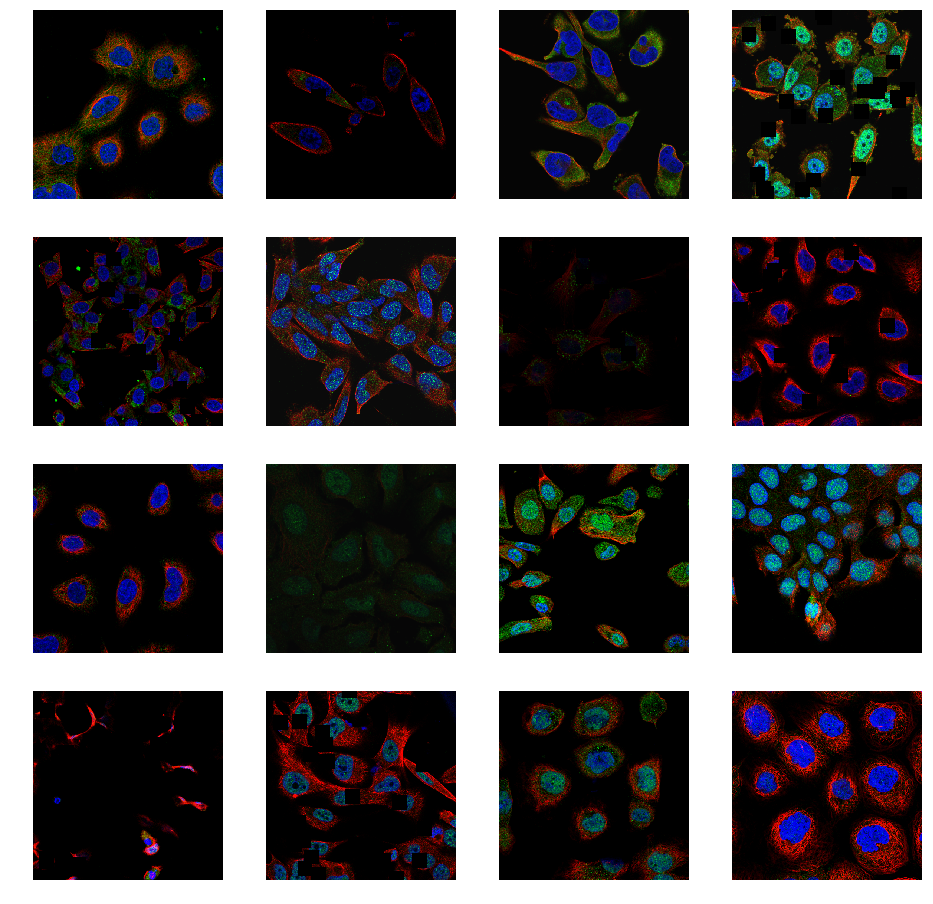

In [10]:
sz = 512
bs =16

md = get_data(sz,bs)

x,y = next(iter(md.trn_dl))
x.shape, y.shape

def display_imgs(x):
    columns = 4
    bs = x.shape[0]
    rows = min((bs+3)//4,4)
    fig=plt.figure(figsize=(columns*4, rows*4))
    for i in range(rows):
        for j in range(columns):
            idx = i+j*columns
            fig.add_subplot(rows, columns, idx+1)
            plt.axis('off')
            plt.imshow((x[idx,:,:,:3]*255).astype(np.int))
    plt.show()
    
display_imgs(np.asarray(md.trn_ds.denorm(x)))

# Computing image statistics in the train set for normalization

In [8]:
#x_tot = np.zeros(4)
#x2_tot = np.zeros(4)
#for x,y in iter(md.trn_dl):
#    try:
#        x = md.trn_ds.denorm(x).reshape(-1,4)
#        x_tot += x.mean(axis=0)
#        x2_tot += (x**2).mean(axis=0)
#    except:
#        print('broke')
#
#channel_avr = x_tot/len(md.trn_dl)
#channel_std = np.sqrt(x2_tot/len(md.trn_dl) - channel_avr**2)
#channel_avr,channel_std

# Loss function and metrics

In [9]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()
    
def acc(preds,targs,th=0.0):
    preds = (preds > th).int()
    targs = targs.int()
    return (preds==targs).float().mean()

def fbeta(y_pred:torch.Tensor, y_true:torch.Tensor, thresh:float=0.2, beta:float=2, eps:float=1e-9, sigmoid:bool=True) -> torch.Tensor:
    "Computes the f_beta between `y_pred` and `y_true` in a multi-classification task."
    beta2 = beta**2
    if sigmoid: y_pred = y_pred.sigmoid()
    y_pred = (y_pred>thresh).float()
    y_true = y_true.float()
    TP = (y_pred*y_true).sum(dim=1)
    prec = TP/(y_pred.sum(dim=1)+eps)
    rec = TP/(y_true.sum(dim=1)+eps)
    res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
    return res.mean()

def wrapped_partial(func, *args, **kwargs):
    partial_func = partial(func, *args, **kwargs)
    update_wrapper(partial_func, func)
    return partial_func

f1_score_fastai = wrapped_partial(fbeta, thresh=0.5, beta=1)

# Custom ConvnetBuilder

In [10]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
#model = torchvision.models.inception_v3(True).to(device)
#summary(model, (3, 299, 299))
#
#ar = inception_v3(True)
#
#ar.Conv2d_1a_3x3.conv
#
#layers_test = cut_model(ar, -1)
#
#layers_test[0].conv
#
#layers_test[0].conv

In [11]:
class ConvnetBuilder_custom():
    def __init__(self, f, c, is_multi, is_reg, ps=None, xtra_fc=None, xtra_cut=0, 
                 custom_head=None, pretrained=True):
        self.f,self.c,self.is_multi,self.is_reg,self.xtra_cut = f,c,is_multi,is_reg,xtra_cut
        if xtra_fc is None: xtra_fc = [512]
        if ps is None: ps = [0.25]*len(xtra_fc) + [0.5]
        self.ps,self.xtra_fc = ps,xtra_fc

        if f in model_meta: cut,self.lr_cut = model_meta[f]
        else: cut,self.lr_cut = 0,0
        cut-=xtra_cut
        layers = cut_model(f(pretrained), cut)
        
        #replace first convolutional layer by 4->64 while keeping corresponding weights
        #and initializing new weights with channel 1 weights
        if f in [inception_4]:
            w = layers[0].conv.weight
            layers[0].conv = nn.Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
            layers[0].conv.weight = torch.nn.Parameter(torch.cat((w,w[:,:1,:,:]),dim=1))
                          
        if f in [inception_v3]:
            #w = layers[0].Conv2d_1a_3x3.conv.weight
            #layers[0].Conv2d_1a_3x3.conv = nn.Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
            #layers[0].Conv2d_1a_3x3.conv.weight = torch.nn.Parameter(torch.cat((w,w[:,:1,:,:]),dim=1))
            w = layers[0].conv.weight
            layers[0].conv = nn.Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
            layers[0].conv.weight = torch.nn.Parameter(torch.cat((w,w[:,:1,:,:]),dim=1))
            
        if f in [resnet18, resnet34, resnet50, resnet101, resnet152]:
            w = layers[0].weight
            layers[0] = nn.Conv2d(4,64,kernel_size=(7,7),stride=(2,2),padding=(3, 3), bias=False)
            #layers[0].weight = torch.nn.Parameter(torch.cat((w,torch.zeros(64,1,7,7)),dim=1)) #init with zeros
            layers[0].weight = torch.nn.Parameter(torch.cat((w,w[:,:1,:,:]),dim=1)) # init with weights of 1st channel

        #else:
            #raise ValueError('Function f for creating the model not supported!')
        
        self.nf = model_features[f] if f in model_features else (num_features(layers)*2)
        if not custom_head: layers += [AdaptiveConcatPool2d(), Flatten()]
        self.top_model = nn.Sequential(*layers)

        n_fc = len(self.xtra_fc)+1
        if not isinstance(self.ps, list): self.ps = [self.ps]*n_fc

        if custom_head: fc_layers = [custom_head]
        else: fc_layers = self.get_fc_layers()
        self.n_fc = len(fc_layers)
        self.fc_model = to_gpu(nn.Sequential(*fc_layers))
        if not custom_head: apply_init(self.fc_model, kaiming_normal)
        self.model = to_gpu(nn.Sequential(*(layers+fc_layers)))

    @property
    def name(self): return f'{self.f.__name__}_{self.xtra_cut}'

    def create_fc_layer(self, ni, nf, p, actn=None):
        res=[nn.BatchNorm1d(num_features=ni)]
        if p: res.append(nn.Dropout(p=p))
        res.append(nn.Linear(in_features=ni, out_features=nf))
        if actn: res.append(actn)
        return res

    def get_fc_layers(self):
        res=[]
        ni=self.nf
        for i,nf in enumerate(self.xtra_fc):
            res += self.create_fc_layer(ni, nf, p=self.ps[i], actn=nn.ReLU())
            ni=nf
        final_actn = nn.Sigmoid() if self.is_multi else nn.LogSoftmax()
        if self.is_reg: final_actn = None
        res += self.create_fc_layer(ni, self.c, p=self.ps[-1], actn=final_actn)
        return res

    def get_layer_groups(self, do_fc=False):
        if do_fc:
            return [self.fc_model]
        idxs = [self.lr_cut]
        c = children(self.top_model)
        if len(c)==3: c = children(c[0])+c[1:]
        lgs = list(split_by_idxs(c,idxs))
        return lgs+[self.fc_model]
    
class ConvLearner(Learner):
    def __init__(self, data, models, precompute=False, **kwargs):
        self.precompute = False
        super().__init__(data, models, **kwargs)
        if hasattr(data, 'is_multi') and not data.is_reg and self.metrics is None:
            self.metrics = [accuracy_thresh(0.5)] if self.data.is_multi else [accuracy]
        if precompute: self.save_fc1()
        self.freeze()
        self.precompute = precompute

    def _get_crit(self, data):
        if not hasattr(data, 'is_multi'): return super()._get_crit(data)

        return F.l1_loss if data.is_reg else F.binary_cross_entropy if data.is_multi else F.nll_loss

    @classmethod
    def pretrained(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                   pretrained=True, **kwargs):
        models = ConvnetBuilder_custom(f, data.c, data.is_multi, data.is_reg,
            ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=pretrained)
        return cls(data, models, precompute, **kwargs)

    @classmethod
    def lsuv_learner(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                  needed_std=1.0, std_tol=0.1, max_attempts=10, do_orthonorm=False, **kwargs):
        models = ConvnetBuilder(f, data.c, data.is_multi, data.is_reg,
            ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=False)
        convlearn=cls(data, models, precompute, **kwargs)
        convlearn.lsuv_init()
        return convlearn
    
    @property
    def model(self): return self.models.fc_model if self.precompute else self.models.model
    
    def half(self):
        if self.fp16: return
        self.fp16 = True
        if type(self.model) != FP16: self.models.model = FP16(self.model)
        if not isinstance(self.models.fc_model, FP16): self.models.fc_model = FP16(self.models.fc_model)
    def float(self):
        if not self.fp16: return
        self.fp16 = False
        if type(self.models.model) == FP16: self.models.model = self.model.module.float()
        if type(self.models.fc_model) == FP16: self.models.fc_model = self.models.fc_model.module.float()

    @property
    def data(self): return self.fc_data if self.precompute else self.data_

    def create_empty_bcolz(self, n, name):
        return bcolz.carray(np.zeros((0,n), np.float32), chunklen=1, mode='w', rootdir=name)

    def set_data(self, data, precompute=False):
        super().set_data(data)
        if precompute:
            self.unfreeze()
            self.save_fc1()
            self.freeze()
            self.precompute = True
        else:
            self.freeze()

    def get_layer_groups(self):
        return self.models.get_layer_groups(self.precompute)

    def summary(self):
        precompute = self.precompute
        self.precompute = False
        res = super().summary()
        self.precompute = precompute
        return res

    def get_activations(self, force=False):
        tmpl = f'_{self.models.name}_{self.data.sz}.bc'
        # TODO: Somehow check that directory names haven't changed (e.g. added test set)
        names = [os.path.join(self.tmp_path, p+tmpl) for p in ('x_act', 'x_act_val', 'x_act_test')]
        if os.path.exists(names[0]) and not force:
            self.activations = [bcolz.open(p) for p in names]
        else:
            self.activations = [self.create_empty_bcolz(self.models.nf,n) for n in names]

    def save_fc1(self):
        self.get_activations()
        act, val_act, test_act = self.activations
        m=self.models.top_model
        if len(self.activations[0])!=len(self.data.trn_ds):
            predict_to_bcolz(m, self.data.fix_dl, act)
        if len(self.activations[1])!=len(self.data.val_ds):
            predict_to_bcolz(m, self.data.val_dl, val_act)
        if self.data.test_dl and (len(self.activations[2])!=len(self.data.test_ds)):
            if self.data.test_dl: predict_to_bcolz(m, self.data.test_dl, test_act)

        self.fc_data = ImageClassifierData.from_arrays(self.data.path,
                (act, self.data.trn_y), (val_act, self.data.val_y), self.data.bs, classes=self.data.classes,
                test = test_act if self.data.test_dl else None, num_workers=8)

    def freeze(self):
        self.freeze_to(-1)

    def unfreeze(self):
        self.freeze_to(0)
        self.precompute = False

    def predict_array(self, arr):
        precompute = self.precompute
        self.precompute = False
        pred = super().predict_array(arr)
        self.precompute = precompute
        return pred

# Training

In [12]:
arch = resnet34

## size 128

In [13]:
sz = 128 #image size
bs = 64 #batch size
md = get_data(sz,bs)
if(arch in [inception_v3]):
    learner = ConvLearner.pretrained(arch, md, ps=0.5, xtra_cut=1) #dropout 50%
else:
    learner = ConvLearner.pretrained(arch, md, ps=0.5, xtra_cut=0) #dropout 50%
learner.opt_fn = optim.Adam
learner.clip = 1.0 #gradient clipping
learner.crit = FocalLoss()
learner.metrics = [acc, f1_score_fastai]
learner.summary

<bound method ConvLearner.summary of Sequential(
  (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inpla

In [14]:
#import warnings
#warnings.filterwarnings('ignore')

 76%|███████▌  | 365/480 [01:49<00:27,  4.14it/s, loss=9.17]

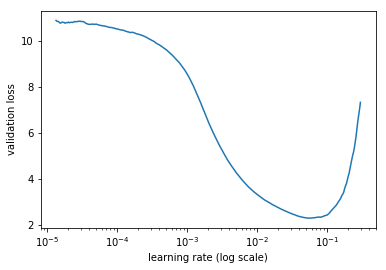

In [15]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.lr_find()
learner.sched.plot()

First, I train only the head of the model while keeping the rest frozen. It allows to avoid corruption of the pretrained weights at the initial stage of training due to random initialization of the head layers. So the power of transfer learning is fully utilized when the training is continued.

In [16]:
lr = 3e-3
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lr,1)

epoch      trn_loss   val_loss   acc        fbeta           
    0      1.369944   1.602336   0.93597    0.147287  


In [17]:
learner.unfreeze()
lrs=np.array([lr/10,lr/3,lr])

In [18]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lrs/4,4,cycle_len=2,use_clr=(10,20))

epoch      trn_loss   val_loss   acc        fbeta           
    0      1.183255   1.404616   0.940212   0.235075  
    1      1.109011   1.323283   0.942231   0.269255        
    2      1.082521   1.297219   0.942998   0.286866        
    3      1.032603   1.236901   0.944672   0.335966        
    4      1.03789    1.24412    0.944301   0.339366        
    5      0.992135   1.192487   0.946869   0.383201         
    6      1.006257   1.221264   0.946077   0.364479         
    7      0.946129   1.149705   0.948658   0.412134         


In [ ]:
learner.sched.plot_lr()

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lrs/16,2,cycle_len=4,use_clr=(10,20))

epoch      trn_loss   val_loss   acc        fbeta            
    0      0.934646   1.151583   0.948505   0.43642   
    1      0.901279   1.128606   0.949438   0.431313         
    2      0.872353   1.129006   0.949208   0.439796         
 65%|██████▌   | 312/480 [01:44<00:51,  3.29it/s, loss=0.866]

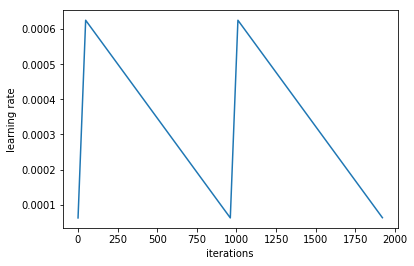

In [25]:
learner.sched.plot_lr()

In [26]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lrs/32,1,cycle_len=8,use_clr=(10,20))

epoch      trn_loss   val_loss   acc        fbeta             
    0      0.052067   0.060599   0.525454   0.138051  
    1      0.052216   0.060985   0.420534   0.131336          
    2      0.052129   0.061059   0.487439   0.151868          
    3      0.052489   0.061014   0.585318   0.14278           
    4      0.051763   0.060897   0.45791    0.136611          
    5      0.052278   0.060874   0.589599   0.156817          
  0%|          | 0/240 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
learner.sched.plot_lr()

In [27]:
name = 'resnet34_sz128_bs64_fastaiV07_base(all_cls)_and_extra_data(only_cls:[8, 9, 10, 15, 17, 20,24, 26, 27])_pngs_512'

In [28]:
learner.save(name)

## size 256

## size 512

# new


## Validation score

Evaluate the score with using TTA (test time augmentation).

In [18]:
md = get_data(sz,bs,is_test=True)
learner.set_data(md)
preds,y = learner.TTA(n_aug=8)
preds = np.stack(preds, axis=-1)
pred = preds.mean(axis=-1)

Instead of 0.5, one can adjust the values of the threshold for each class individually to boost the score. The code below does it automatically.

In [19]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def F1_soft(preds,targs,th=0.0,d=25.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = np.zeros(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*p), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [21]:
th = fit_val(pred,y)
print('Thresholds: ',th)
print('F1 macro: ', sklearn.metrics.f1_score(y, pred>th, average='macro'))
print('F1 macro (th = 0.0): ', sklearn.metrics.f1_score(y, pred>0.0, average='macro'))
print('F1 micro: ', sklearn.metrics.f1_score(y, pred>th, average='micro'))

Thresholds:  [   0.23284   -4.6822    -2.20151   -5.5593    -4.11182   -4.42344   -5.74055   -3.41199 -111.13709
  -91.22849 -111.137     -6.06392  -17.07058  -21.92735   -4.72764 -616.29556  -16.11333  -20.53118
  -13.92889   -4.63747  -22.94003   -2.36114  -15.23622   -3.9      -36.47363   -0.55325  -12.57494
 -254.37864]
F1 macro:  0.12655504845302323
F1 macro (th = 0.0):  0.07883366413862317
F1 micro:  0.12232311118725372


Using CV to prevent overfitting the thresholds:

In [22]:
from sklearn.model_selection import train_test_split
th, score, cv = 0,0,10
for i in range(cv):
    xt,xv,yt,yv = train_test_split(pred,y,test_size=0.5,random_state=i)
    th_i = fit_val(xt,yt)
    th += th_i
    score +=  sklearn.metrics.f1_score(yv, xv>th_i, average='macro')
th/=cv
score/=cv
print('Thresholds: ',th)
print('F1 macro avr:',score)
print('F1 macro: ', sklearn.metrics.f1_score(y, pred>th, average='macro'))
print('F1 micro: ', sklearn.metrics.f1_score(y, pred>th, average='micro'))


print('Fractions: ',(pred > th).mean(axis=0))
print('Fractions (true): ',(y > 0.5).mean(axis=0))

Thresholds:  [   0.30396   -4.72532   -2.16602   -6.53015   -4.04429   -4.23195   -5.94256   -3.32486 -117.60957
 -104.31717 -136.37827   -5.94358  -17.73015  -22.43117   -4.74827 -492.12927  -19.22988  -20.40944
  -12.91663   -4.46856  -23.79101   -2.60108  -15.39793   -4.09964  -38.69657   -0.53792  -12.27492
 -257.66132]
F1 macro avr: 0.1264773877202845
F1 macro:  0.1264344327784321
F1 micro:  0.12195928161306513
Fractions:  [0.37639 1.      1.      1.      1.      1.      1.      1.      1.      1.      1.      1.      1.
 1.      1.      1.      1.      1.      1.      1.      1.      1.      1.      1.      1.      1.
 1.      1.     ]
Fractions (true):  [0.34526 0.06977 0.10483 0.06369 0.07478 0.07191 0.06261 0.08265 0.0136  0.01503 0.0136  0.06082 0.03542
 0.03113 0.06941 0.00572 0.03649 0.0322  0.03936 0.07013 0.03041 0.10089 0.03757 0.07692 0.02397 0.2297
 0.0415  0.00894]


Plot the distribution of lables to see how the model performs.

Nucleoplasm 0 0.7734258800198315 0.3039567625135419


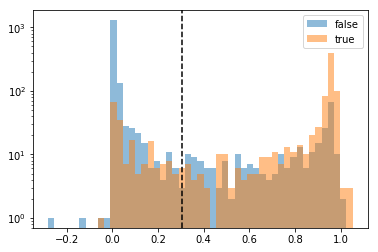

Nuclear membrane 1 0.13043478260869565 -4.725320939704674


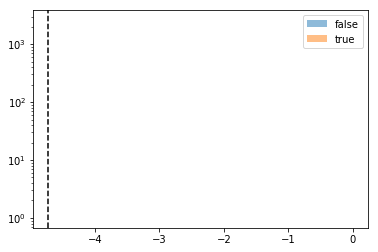

Nucleoli 2 0.18976683937823832 -2.1660179078774133


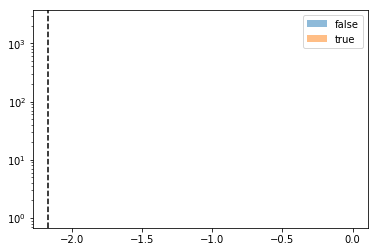

Nucleoli fibrillar center 3 0.11974436596030946 -6.530152899371272


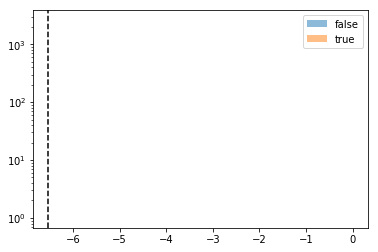

Nuclear speckles 4 0.1391478029294274 -4.044292561567119


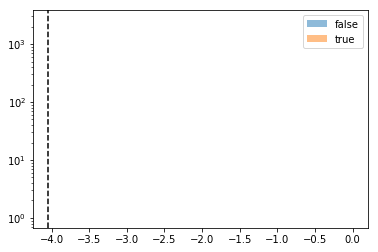

Nuclear bodies 5 0.13417890520694256 -4.2319521898145975


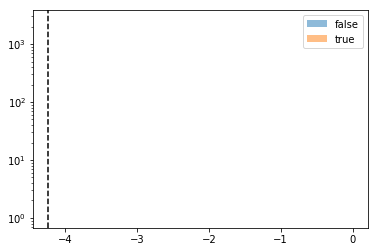

Endoplasmic reticulum 6 0.11784511784511782 -5.942558819022766


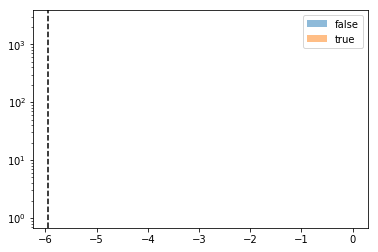

Golgi apparatus 7 0.15267680105750164 -3.324860730995483


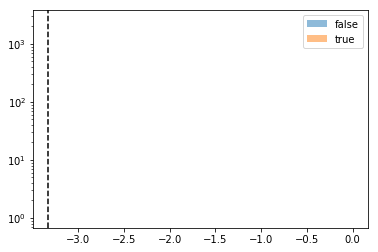

Peroxisomes 8 0.02682668549241087 -117.60956939178713


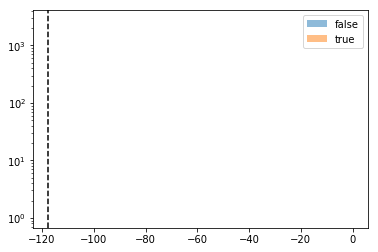

Endosomes 9 0.029608741628480793 -104.31717025623952


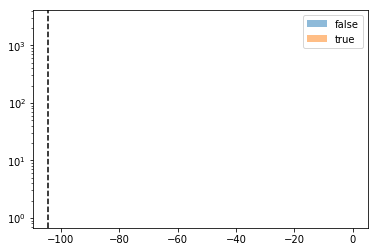

Lysosomes 10 0.02682668549241087 -136.3782677962115


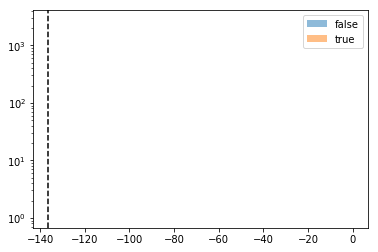

Intermediate filaments 11 0.11467116357504217 -5.9435772463082035


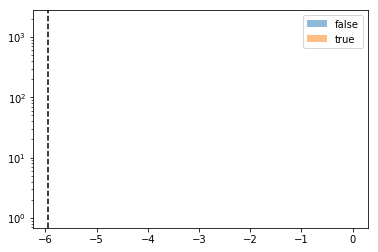

Actin filaments 12 0.06841741534208708 -17.73015406909825


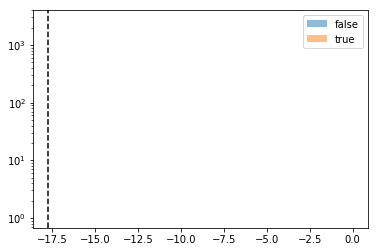

Focal adhesion sites 13 0.06037473976405274 -22.431169603081706


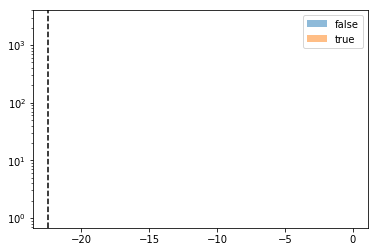

Microtubules 14 0.12980930076948813 -4.748274256828977


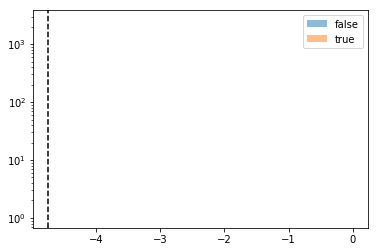

Microtubule ends 15 0.011383849163998577 -492.12926974897346


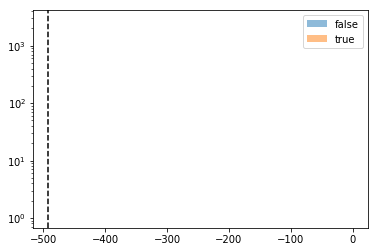

Cytokinetic bridge 16 0.07041767345529858 -19.229880008296423


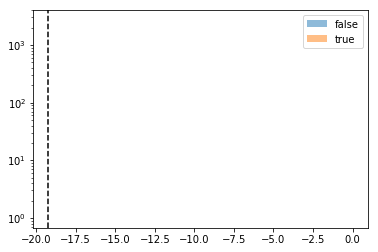

Mitotic spindle 17 0.06239168110918545 -20.409441120204384


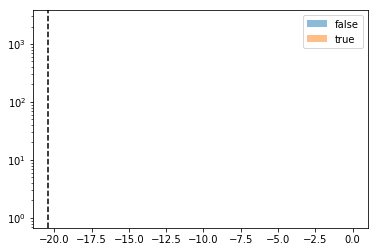

Microtubule organizing center 18 0.0757314974182444 -12.916629070231199


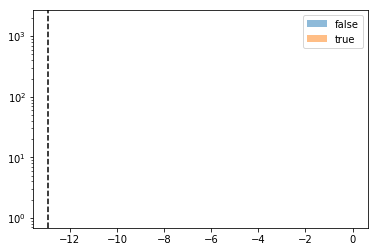

Centrosome 19 0.13105984620528252 -4.46855842165637


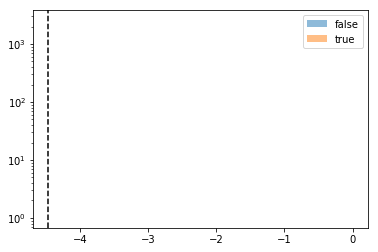

Lipid droplets 20 0.059027777777777776 -23.791013906348777


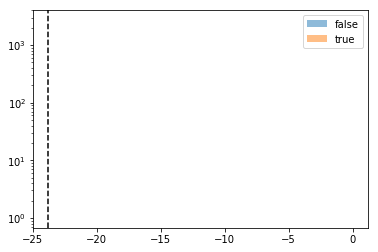

Plasma membrane 21 0.1832954176145596 -2.6010847126831806


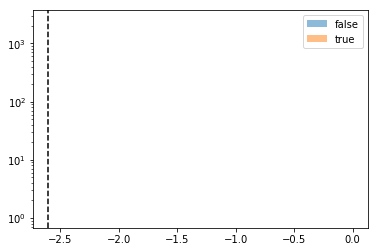

Cell junctions 22 0.07241379310344828 -15.397926508465122


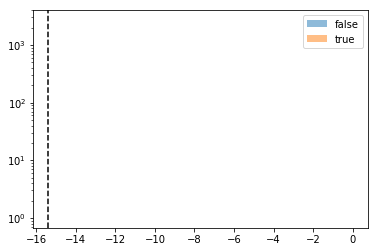

Mitochondria 23 0.14285714285714288 -4.099643579147251


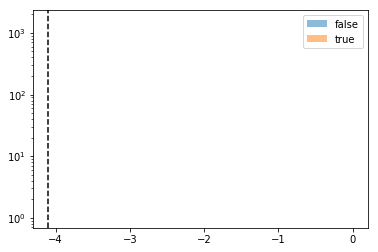

Aggresome 24 0.04682040531097135 -38.69657095373215


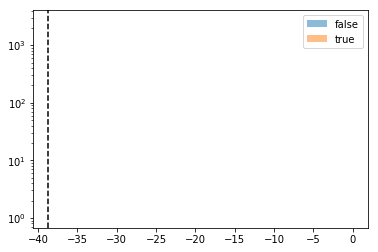

Cytosol 25 0.37358161187081756 -0.5379153830053822


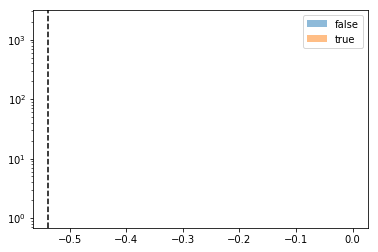

Cytoplasmic bodies 26 0.07969769838543457 -12.274918599725641


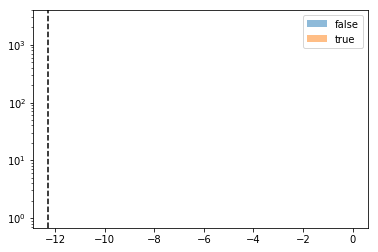

Rods & rings 27 0.01773049645390071 -257.6613158984118


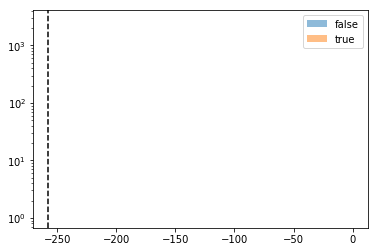

In [23]:
f1 =  sklearn.metrics.f1_score(y, pred>th, average=None)
for i in range(len(name_label_dict)):
    bins = np.linspace(pred[:,i].min(), pred[:,i].max(), 50)
    plt.hist(pred[y[:,i] == 0][:,i], bins, alpha=0.5, log=True, label='false')
    plt.hist(pred[y[:,i] == 1][:,i], bins, alpha=0.5, log=True, label='true')
    plt.legend(loc='upper right')
    print(name_label_dict[i],i, f1[i], th[i])
    plt.axvline(x=th[i], color='k', linestyle='--')
    plt.show()

## Submission

###  Preds for single model

In [24]:
preds_t,y_t = learner.TTA(n_aug=16,is_test=True)
preds_t = np.stack(preds_t, axis=-1)
#preds_t = sigmoid_np(preds_t)
pred_t = preds_t.mean(axis=-1)

### Ensembling

In [25]:
arch_list = [inception_4, resnet34, resnet50, resnet101]
dict_arch_savedModel = {inception_4:'inception_4_sz512_bs16_fastaiV07', 
                        resnet34:'ResNet34_512_fastaiV07_4thChannel_with_1stChannelWeights_init', 
                        resnet50:'resnet50_sz512_bs16_fastaiV07',
                        resnet101: 'resnet101_sz512_bs16_fastaiV07'}
name = f'{str(list(dict_arch_savedModel.values()))}_ensembled'; name

"['inception_4_sz512_bs16_fastaiV07', 'ResNet34_512_fastaiV07_4thChannel_with_1stChannelWeights_init', 'resnet50_sz512_bs16_fastaiV07', 'resnet101_sz512_bs16_fastaiV07']_ensembled"

In [26]:
predLists_t = []
for arch in arch_list:    
    md = get_data(sz,bs)
    learner = ConvLearner.pretrained(arch, md, ps=0.5) #dropout 50%
    learner.opt_fn = optim.Adam
    learner.clip = 1.0 #gradient clipping
    learner.crit = FocalLoss()
    learner.metrics = [acc]
    learner.load(dict_arch_savedModel[arch])
    preds_t,y_t = learner.TTA(n_aug=16,is_test=True)
    preds_t = np.stack(preds_t, axis=-1)
    #preds_t = sigmoid_np(preds_t)
    pred_t = preds_t.mean(axis=-1)
    predLists_t.append(pred_t)

calculate the prediction average for each image

In [27]:
pred_t_averaged = np.zeros(shape=(len(test_names), len(name_label_dict)))
pred_t_averaged.shape
for i in range(len(test_names)):
    p = np.zeros(len(name_label_dict))
    for pList in predLists_t:
        p += pList[i]
    average = p/len(predLists_t)
    pred_t_averaged[i] = average

pred_t = pred_t_averaged

### Submission files with different thresholds

**It is very important to keep the same order of ids as in the sample submission** https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/69366#409041 since the competition metric relies only on the order of recods ignoring IDs.

In [25]:
def save_pred(pred, th=0.0, fname=f'{name}.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
    
    df = pd.DataFrame({'Id':learner.data.test_ds.fnames,'Predicted':pred_list})
    df.sort_values(by='Id').to_csv(fname, header=True, index=False)

In [26]:
th_t = np.array([0.565,0.39,0.55,0.345,0.33,0.39,0.33,0.45,0.38,0.39,
               0.34,0.42,0.31,0.38,0.49,0.50,0.38,0.43,0.46,0.40,
               0.39,0.505,0.37,0.47,0.41,0.545,0.32,0.1])
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t)

Fractions:  [0.37233 0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.     ]


Automatic fitting the thresholds based on the public LB statistics.

In [27]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]
# I replaced 0 by 0.01 since there may be a rounding error leading to 0

In [28]:
def Count_soft(preds,th=0.0,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = np.zeros(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*p), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [29]:
th_t = fit_test(pred_t,lb_prob)
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.0): ',(pred_t > 0.0).mean(axis=0))

Thresholds:  [0.60804 0.06165 0.05017 0.05527 0.05017 0.05017 0.06165 0.05017 0.0919  0.0919  0.0919  0.06165 0.06165
 0.08481 0.06165 0.0919  0.07036 0.08481 0.07036 0.05527 0.0919  0.03871 0.07036 0.05017 0.0919  0.02502
 0.07036 0.0919 ]
Fractions:  [0.36242 0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.     ]
Fractions (th = 0.0):  [0.99769 0.53811 0.11075 0.8296  0.00718 0.00385 0.00145 0.99487 0.99855 0.38634 0.59357 0.98487 0.09161
 0.74372 0.0053  0.9953  0.94668 0.00342 0.99846 0.00103 0.42514 0.00265 0.00043 0.63041 0.4248  0.43352
 0.00222 0.00427]


In [30]:
save_pred(pred_t,th_t,f'{name}_f.csv')

Save also predictions for a threshold calculated based on the validation set and constant value 0.5:

In [31]:
save_pred(pred_t,th,f'{name}_v.csv')
save_pred(pred_t,0.0,f'{name}_0.csv')

Try using the threshold from validation set for classes not present in the public LB:

In [32]:
class_list = [8,9,10,15,20,24,27]
for i in class_list:
    th_t[i] = th[i]
save_pred(pred_t,th_t,f'{name}_c.csv')

Try fitting thresholds based on the frequency of classes in the train dataset:

In [33]:
labels = pd.read_csv(LABELS).set_index('Id')
label_count = np.zeros(len(name_label_dict))
for label in labels['Target']:
    l = [int(i) for i in label.split()]
    label_count += np.eye(len(name_label_dict))[l].sum(axis=0)
label_fraction = label_count.astype(np.float)/len(labels)
label_count, label_fraction

(array([13197.,  1254.,  3655.,  1591.,  1941.,  2545.,  1060.,  2874.,   217.,   197.,   182.,  1102.,
          700.,   537.,  1128.,    63.,   604.,   446.,   960.,  1528.,   438.,  3891.,   846.,  2993.,
          427.,  8632.,   704.,   127.]),
 array([0.40533, 0.03851, 0.11226, 0.04887, 0.05961, 0.07817, 0.03256, 0.08827, 0.00666, 0.00605, 0.00559,
        0.03385, 0.0215 , 0.01649, 0.03464, 0.00193, 0.01855, 0.0137 , 0.02948, 0.04693, 0.01345, 0.11951,
        0.02598, 0.09193, 0.01311, 0.26512, 0.02162, 0.0039 ]))

In [34]:
th_t = fit_test(pred_t,label_fraction)
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t,f'{name}_t.csv')

Thresholds:  [0.38609 0.06435 0.04136 0.05937 0.05517 0.04935 0.06783 0.0467  0.10008 0.10203 0.10362 0.06703 0.07636
 0.08176 0.06655 0.12491 0.07937 0.08553 0.06988 0.06022 0.0859  0.03994 0.07248 0.04581 0.08642 0.02039
 0.07624 0.11085]
Fractions:  [0.40523 0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.     ]


# old

## Validation score

Evaluate the score with using TTA (test time augmentation).

In [ ]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

preds,y = learner.TTA(n_aug=16)
preds = np.stack(preds, axis=-1)
preds = sigmoid_np(preds)
pred = preds.max(axis=-1)

Instead of 0.5, one can adjust the values of the threshold for each class individually to boost the score. The code below does it automatically.

In [ ]:
def F1_soft(preds,targs,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [ ]:
th = fit_val(pred,y)
th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',sklearn.metrics.f1_score(y, pred>th, average='macro'))
print('F1 macro (th = 0.5): ',sklearn.metrics.f1_score(y, pred>0.5, average='macro'))
print('F1 micro: ',sklearn.metrics.f1_score(y, pred>th, average='micro'))

In [ ]:
print('Fractions: ',(pred > th).mean(axis=0))
print('Fractions (true): ',(y > th).mean(axis=0))

## Submission

### Preds for single model

In [ ]:
preds_t,y_t = learner.TTA(n_aug=16,is_test=True)
preds_t = np.stack(preds_t, axis=-1)
preds_t = sigmoid_np(preds_t)
pred_t = preds_t.max(axis=-1) #max works better for F1 macro score

### Ensembling

In [ ]:
arch_list = [inception_4, resnet34, resnet50, resnet101]
dict_arch_savedModel = {inception_4:'inception_4_sz512_bs16_fastaiV07', 
                        resnet34:'ResNet34_512_fastaiV07_4thChannel_with_1stChannelWeights_init', 
                        resnet50:'resnet50_sz512_bs16_fastaiV07',
                        resnet101: 'resnet101_sz512_bs16_fastaiV07'}
name = f'{str(list(dict_arch_savedModel.values()))}_ensembled'; name

In [ ]:
predLists_t = []
for arch in arch_list:    
    md = get_data(sz,bs)
    learner = ConvLearner.pretrained(arch, md, ps=0.5) #dropout 50%
    learner.opt_fn = optim.Adam
    learner.clip = 1.0 #gradient clipping
    learner.crit = FocalLoss()
    learner.metrics = [acc]
    learner.load(dict_arch_savedModel[arch])
    preds_t,y_t = learner.TTA(n_aug=16,is_test=True)
    preds_t = np.stack(preds_t, axis=-1)
    preds_t = sigmoid_np(preds_t)
    pred_t = preds_t.max(axis=-1)
    predLists_t.append(pred_t)

calculate the prediction average for each image

In [ ]:
pred_t_averaged = np.zeros(shape=(len(test_names), len(name_label_dict)))
pred_t_averaged.shape
for i in range(len(test_names)):
    p = np.zeros(len(name_label_dict))
    for pList in predLists_t:
        p += pList[i]
    average = p/len(predLists_t)
    pred_t_averaged[i] = average

pred_t = pred_t_averaged

### Submission files with different thresholds

It is very important to keep the same order of ids as in the sample submission https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/69366#409041 since the competition metric relies only on the order of recods ignoring IDs.


In [ ]:
def save_pred(pred, th=0.5, fname='protein_classification.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
        
    sample_df = pd.read_csv(SAMPLE)
    sample_list = list(sample_df.Id)
    pred_dic = dict((key, value) for (key, value) 
                in zip(learner.data.test_ds.fnames,pred_list))
    pred_list_cor = [pred_dic[id] for id in sample_list]
    df = pd.DataFrame({'Id':sample_list,'Predicted':pred_list_cor})
    df.to_csv(fname, header=True, index=False)

In [ ]:
th_t = np.array([0.565,0.39,0.55,0.345,0.33,0.39,0.33,0.45,0.38,0.39,
               0.34,0.42,0.31,0.38,0.49,0.50,0.38,0.43,0.46,0.40,
               0.39,0.505,0.37,0.47,0.41,0.545,0.32,0.1])
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t)

Automatic fitting the thresholds based on the public LB statistics.


In [ ]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]
# I replaced 0 by 0.01 since there may be a rounding error leading to 0

In [ ]:
def Count_soft(preds,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [ ]:
th_t = fit_test(pred_t,lb_prob)
th_t[th_t<0.1] = 0.1
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.5): ',(pred_t > 0.5).mean(axis=0))

In [ ]:
save_pred(pred_t,th_t, f'{name}_f.csv')

In [ ]:
save_pred(pred_t,th,f'{name}_v.csv')
save_pred(pred_t,0.5,f'{name}_05.csv')

In [ ]:
class_list = [8,9,10,15,20,24,27]
for i in class_list:
    th_t[i] = th[i]
save_pred(pred_t,th_t,f'{name}_c.csv')

In [ ]:
labels = pd.read_csv(LABELS).set_index('Id')
label_count = np.zeros(len(name_label_dict))
for label in labels['Target']:
    l = [int(i) for i in label.split()]
    label_count += np.eye(len(name_label_dict))[l].sum(axis=0)
label_fraction = label_count.astype(np.float)/len(labels)
label_count, label_fraction

In [ ]:
th_t = fit_test(pred_t,label_fraction)
th_t[th_t<0.05] = 0.05
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t,f'{name}_t.csv')